In [1]:
import os
import time
import numpy as np
import pandas as pd
import scipy.stats
from scipy.optimize import curve_fit
from scipy import interpolate as ip
import matplotlib.pyplot as plt
import seaborn as sns
import copy
from astropy.io import ascii
from astropy.table import Table
from scipy.constants import c
from IPython.display import display, Math
from scipy.stats import gaussian_kde

import astropy.io.fits as fits
from matplotlib.colors import LogNorm
from astropy.visualization import (
    imshow_norm,
    MinMaxInterval,
    ManualInterval,
    SqrtStretch,
    LogStretch,
    AsinhStretch,
)
from skimage.transform import resize

pd.set_option("display.max_columns", 400)
plt.rcParams.update({"font.size": 16})

In [2]:
#constants

L_sol = 3.83e26 #Watts

In [3]:
#Every function

def new(x, a, b):
    b=b
    return 1/(1+np.exp(-(x-a)/a))


## Paths

In [4]:
cat_dirSK = "/net/virgo01/data/users/ebbers/BSc_Thesis/SKIRTOR/3-30SK/"
cat_dirF = "/net/virgo01/data/users/ebbers/BSc_Thesis/Fritz/3-30F/"

COSMOS_dirSK = "/net/virgo01/data/users/ebbers/BSc_Thesis/COSMOS/SKIRTOR/SK3-30/"
COSMOS_dirF= "/net/virgo01/data/users/ebbers/BSc_Thesis/COSMOS/Fritz/F3-30/"

sed_dirSK = cat_dirSK
sed_dirF = cat_dirF

cat_nameSK = "results_3-30SK.fits"
cat_nameF = "results_3-30F.fits"
#Ant_COSMOS_SK = "CIGALE_COSMOS2020_XRAY_FIR_COSMOS-Web_z_mass_chi_sel_cutouts.fits" #Antonio's results
COSMOS_nameSK = 'results_SK3-30.fits'
COSMOS_nameF = 'results_COSMOSF3-30.fits'

observations_fileSK = cat_dirSK + "observations_3-30SK.fits"
observations_fileF = cat_dirF + "observations_3-30F.fits"
COSMOS_observations_fileF = COSMOS_dirF + 'observations_COSMOSF3-30.fits'
COSMOS_observations_fileSK = COSMOS_dirSK + 'observations_SK3-30.fits'

# $3-30 \mu m$ plots

In [5]:
# Creating panda dataframes for the data
#SKIRTOR

IRlum_SK = pd.read_csv('IRlum_3-30SK.csv')

IRlum_SK = IRlum_SK.loc[IRlum_SK['redshift'] < 0.5]

#IRlum_ANT = pd.read_csv('IRlum_ANT.csv')

IRlum_COSMOSSK = pd.read_csv('IRlum_3-30SK_COSMOS.csv')

IRlum_SK = pd.concat([IRlum_SK, IRlum_COSMOSSK], ignore_index=True)

IRlum_SK

,id,redshift,IRLum_tot,fAGN_IR,fAGN_err,best_fAGN
0,3.989471e+16,0.340000,8.996002e+36,0.254797,0.241456,0.70
1,3.989485e+16,0.196839,3.124996e+36,0.176481,0.087811,0.10
2,3.989485e+16,0.400000,9.712273e+36,0.706946,0.095646,0.70
3,3.989498e+16,0.373100,1.472279e+37,0.331201,0.197466,0.40
4,3.989499e+16,0.430000,6.176537e+36,0.268682,0.262558,0.55
...,...,...,...,...,...,...
34626,9.643850e+05,2.415800,7.147979e+37,0.526794,0.377385,0.99
34627,9.643860e+05,1.306800,1.758638e+36,0.589256,0.208200,0.70
34628,9.643910e+05,2.898300,2.004169e+36,0.341509,0.283239,0.30
34629,9.644280e+05,1.258700,8.580657e+36,0.382373,0.157672,0.55


In [6]:
# Creating panda dataframes for the data
#Fritz

IRlum_F = pd.read_csv('IRlum_3-30F.csv')

IRlum_F = IRlum_F.loc[IRlum_F['redshift'] < 0.5]

IRlum_COSMOSF = pd.read_csv('IRlum_3-30F_COSMOS.csv')

IRlum_F = pd.concat([IRlum_F, IRlum_COSMOSF], ignore_index=True)

IRlum_F

,id,redshift,IRLum_tot,fAGN_IR,fAGN_err,best_fAGN
0,3.989031e+16,0.330000,2.971111e+36,0.323506,0.316410,0.30
1,3.989032e+16,0.490000,3.237891e+37,0.379175,0.323331,0.85
2,3.989471e+16,0.340000,1.575059e+37,0.408155,0.309429,0.85
3,3.989485e+16,0.196839,3.767558e+36,0.174020,0.077509,0.30
4,3.989485e+16,0.400000,9.472096e+36,0.704204,0.143411,0.70
...,...,...,...,...,...,...
46489,9.643850e+05,2.415800,1.307938e+38,0.428911,0.348010,0.99
46490,9.643860e+05,1.306800,3.296182e+36,0.557427,0.264928,0.85
46491,9.643910e+05,2.898300,1.878090e+36,0.377935,0.318105,0.20
46492,9.644280e+05,1.258700,9.940069e+36,0.544781,0.240343,0.70


## $L_{IR}(3-30)\ vs. bayes.fAGN$

In [7]:
#binning redshift SKIRTOR

z_05SK = pd.DataFrame(columns = ["id", "redshift", "IRLum_tot", "fAGN_IR", "fAGN_err", "best_fAGN"])
z_10SK = pd.DataFrame(columns = ["id", "redshift", "IRLum_tot", "fAGN_IR", "fAGN_err", "best_fAGN"])
z_15SK = pd.DataFrame(columns = ["id", "redshift", "IRLum_tot", "fAGN_IR", "fAGN_err", "best_fAGN"])
z_20SK = pd.DataFrame(columns = ["id", "redshift", "IRLum_tot", "fAGN_IR", "fAGN_err", "best_fAGN"])
z_25SK = pd.DataFrame(columns = ["id", "redshift", "IRLum_tot", "fAGN_IR", "fAGN_err", "best_fAGN"])
z_30SK = pd.DataFrame(columns = ["id", "redshift", "IRLum_tot", "fAGN_IR", "fAGN_err", "best_fAGN"])

for i in IRlum_SK.index:
    if IRlum_SK["redshift"][i] <= 0.5:
        
        z_05SK = pd.concat([z_05SK, pd.DataFrame([[IRlum_SK["id"][i], 
                                               IRlum_SK["redshift"][i], 
                                               IRlum_SK["IRLum_tot"][i], 
                                               IRlum_SK["fAGN_IR"][i],
                                               IRlum_SK["fAGN_err"][i], 
                                               IRlum_SK["best_fAGN"][i]]],  columns=z_05SK.columns)], ignore_index=True)
    
    elif IRlum_SK["redshift"][i] <= 1 and IRlum_SK["redshift"][i] > 0.5:
        
        z_10SK = pd.concat([z_10SK, pd.DataFrame([[IRlum_SK["id"][i], 
                                               IRlum_SK["redshift"][i], 
                                               IRlum_SK["IRLum_tot"][i], 
                                               IRlum_SK["fAGN_IR"][i],
                                               IRlum_SK["fAGN_err"][i], 
                                               IRlum_SK["best_fAGN"][i]]], columns=z_10SK.columns)], ignore_index=True)
    
    elif IRlum_SK["redshift"][i] <= 1.5 and IRlum_SK["redshift"][i] > 1:
        
        z_15SK = pd.concat([z_15SK, pd.DataFrame([[IRlum_SK["id"][i], 
                                               IRlum_SK["redshift"][i], 
                                               IRlum_SK["IRLum_tot"][i], 
                                               IRlum_SK["fAGN_IR"][i],
                                               IRlum_SK["fAGN_err"][i], 
                                               IRlum_SK["best_fAGN"][i]]], columns=z_15SK.columns)], ignore_index=True)
        
    elif IRlum_SK["redshift"][i] <= 2 and IRlum_SK["redshift"][i] > 1.5:
        
        z_20SK = pd.concat([z_20SK, pd.DataFrame([[IRlum_SK["id"][i], 
                                               IRlum_SK["redshift"][i], 
                                               IRlum_SK["IRLum_tot"][i], 
                                               IRlum_SK["fAGN_IR"][i],
                                               IRlum_SK["fAGN_err"][i], 
                                               IRlum_SK["best_fAGN"][i]]], columns=z_20SK.columns)], ignore_index=True)
    
    elif IRlum_SK["redshift"][i] <= 2.5 and IRlum_SK["redshift"][i] > 2:
        
        z_25SK = pd.concat([z_25SK, pd.DataFrame([[IRlum_SK["id"][i], 
                                               IRlum_SK["redshift"][i], 
                                               IRlum_SK["IRLum_tot"][i], 
                                               IRlum_SK["fAGN_IR"][i],
                                               IRlum_SK["fAGN_err"][i], 
                                               IRlum_SK["best_fAGN"][i]]], columns=z_25SK.columns)], ignore_index=True)
    else:
        z_30SK = pd.concat([z_30SK, pd.DataFrame([[IRlum_SK["id"][i], 
                                               IRlum_SK["redshift"][i], 
                                               IRlum_SK["IRLum_tot"][i], 
                                               IRlum_SK["fAGN_IR"][i],
                                               IRlum_SK["fAGN_err"][i], 
                                               IRlum_SK["best_fAGN"][i]]], columns=z_30SK.columns)], ignore_index=True)
    

/var/lib/condor/execute/dir_330080/ipykernel_330467/2150006052.py:13: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  z_05SK = pd.concat([z_05SK, pd.DataFrame([[IRlum_SK["id"][i],
/var/lib/condor/execute/dir_330080/ipykernel_330467/2150006052.py:49: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  z_25SK = pd.concat([z_25SK, pd.DataFrame([[IRlum_SK["id"][i],
/var/lib/condor/execute/dir_330080/ipykernel_330467/2150006052.py:31: FutureWarning: The behavior of DataFrame concatenation with empty or all-N

In [8]:
#binning redshift Fritz

z_05F = pd.DataFrame(columns = ["id", "redshift", "IRLum_tot", "fAGN_IR", "fAGN_err", "best_fAGN"])
z_10F = pd.DataFrame(columns = ["id", "redshift", "IRLum_tot", "fAGN_IR", "fAGN_err", "best_fAGN"])
z_15F = pd.DataFrame(columns = ["id", "redshift", "IRLum_tot", "fAGN_IR", "fAGN_err", "best_fAGN"])
z_20F = pd.DataFrame(columns = ["id", "redshift", "IRLum_tot", "fAGN_IR", "fAGN_err", "best_fAGN"])
z_25F = pd.DataFrame(columns = ["id", "redshift", "IRLum_tot", "fAGN_IR", "fAGN_err", "best_fAGN"])
z_30F = pd.DataFrame(columns = ["id", "redshift", "IRLum_tot", "fAGN_IR", "fAGN_err", "best_fAGN"])

for i in IRlum_F.index:
    if IRlum_F["redshift"][i] <= 0.5:
        
        z_05F = pd.concat([z_05F, pd.DataFrame([[IRlum_F["id"][i], 
                                               IRlum_F["redshift"][i], 
                                               IRlum_F["IRLum_tot"][i], 
                                               IRlum_F["fAGN_IR"][i],
                                               IRlum_F["fAGN_err"][i],
                                               IRlum_F["best_fAGN"][i]]], columns=z_05F.columns)], ignore_index=True)
    
    elif IRlum_F["redshift"][i] <= 1 and IRlum_F["redshift"][i] > 0.5:
        
        z_10F = pd.concat([z_10F, pd.DataFrame([[IRlum_F["id"][i], 
                                               IRlum_F["redshift"][i], 
                                               IRlum_F["IRLum_tot"][i], 
                                               IRlum_F["fAGN_IR"][i],
                                               IRlum_F["fAGN_err"][i],
                                               IRlum_F["best_fAGN"][i]]], columns=z_10F.columns)], ignore_index=True)
    
    elif IRlum_F["redshift"][i] <= 1.5 and IRlum_F["redshift"][i] > 1:
        
        z_15F = pd.concat([z_15F, pd.DataFrame([[IRlum_F["id"][i], 
                                               IRlum_F["redshift"][i], 
                                               IRlum_F["IRLum_tot"][i], 
                                               IRlum_F["fAGN_IR"][i],
                                               IRlum_F["fAGN_err"][i],
                                               IRlum_F["best_fAGN"][i]]], columns=z_15F.columns)], ignore_index=True)
        
    elif IRlum_F["redshift"][i] <= 2 and IRlum_F["redshift"][i] > 1.5:
        
        z_20F = pd.concat([z_20F, pd.DataFrame([[IRlum_F["id"][i], 
                                               IRlum_F["redshift"][i], 
                                               IRlum_F["IRLum_tot"][i], 
                                               IRlum_F["fAGN_IR"][i],
                                               IRlum_F["fAGN_err"][i],
                                               IRlum_F["best_fAGN"][i]]], columns=z_20F.columns)], ignore_index=True)
    
    elif IRlum_F["redshift"][i] <= 2.5 and IRlum_F["redshift"][i] > 2:
        
        z_25F = pd.concat([z_25F, pd.DataFrame([[IRlum_F["id"][i], 
                                               IRlum_F["redshift"][i], 
                                               IRlum_F["IRLum_tot"][i], 
                                               IRlum_F["fAGN_IR"][i],
                                               IRlum_F["fAGN_err"][i],
                                               IRlum_F["best_fAGN"][i]]], columns=z_25F.columns)], ignore_index=True)
    else:
        z_30F = pd.concat([z_30F, pd.DataFrame([[IRlum_F["id"][i], 
                                               IRlum_F["redshift"][i], 
                                               IRlum_F["IRLum_tot"][i], 
                                               IRlum_F["fAGN_IR"][i],
                                               IRlum_F["fAGN_err"][i],
                                               IRlum_F["best_fAGN"][i]]], columns=z_30F.columns)], ignore_index=True)
    

/var/lib/condor/execute/dir_330080/ipykernel_330467/1804933486.py:13: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  z_05F = pd.concat([z_05F, pd.DataFrame([[IRlum_F["id"][i],
/var/lib/condor/execute/dir_330080/ipykernel_330467/1804933486.py:49: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  z_25F = pd.concat([z_25F, pd.DataFrame([[IRlum_F["id"][i],
/var/lib/condor/execute/dir_330080/ipykernel_330467/1804933486.py:31: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entr

[4.23932806e+10 5.00000000e+00]


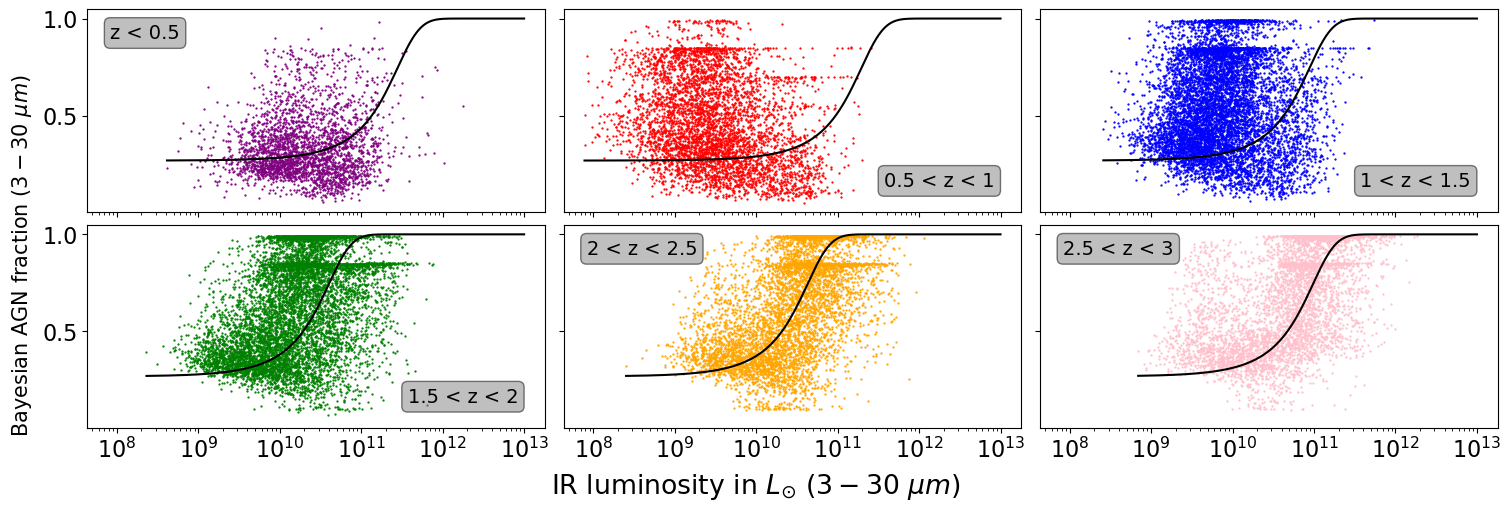

In [9]:
fig, ((ax1,ax2,ax3),(ax4,ax5,ax6)) = plt.subplots(2, 3, figsize=(15,5), sharex=True, sharey=True, layout='constrained')

ax1.scatter(z_05SK["IRLum_tot"]/L_sol, 
             z_05SK["fAGN_IR"],  
             color="purple",
             s=0.4,
             label="Scatter of IR lum vs fAGN with z < 0.5")

ax2.scatter(z_10SK["IRLum_tot"]/L_sol, 
             z_10SK["fAGN_IR"],   
             color="red",
             s=0.4,
             label="Scatter of IR lum vs fAGN with 0.5 < z < 1")

ax3.scatter(z_15SK["IRLum_tot"]/L_sol, 
             z_15SK["fAGN_IR"],  
             color="blue",
             s=0.4,
             label="Scatter of IR lum vs fAGN with 1 < z < 1.5")

ax4.scatter(z_20SK["IRLum_tot"]/L_sol, 
             z_20SK["fAGN_IR"],  
             color="green",
             s=0.4,
             label="Scatter of IR lum vs fAGN with 1.5 < z < 2")

ax5.scatter(z_25SK["IRLum_tot"]/L_sol, 
             z_25SK["fAGN_IR"],  
             color="orange",
             s=0.4,
             label="Scatter of IR lum vs fAGN with 2 < z < 2.5")

ax6.scatter(z_30SK["IRLum_tot"]/L_sol, 
             z_30SK["fAGN_IR"],  
             color="pink",
             s=0.4,
             label="Scatter of IR lum vs fAGN with 2.5 < z")

#Fitting the relation

popt05, pcov05 = curve_fit(new, z_05SK["IRLum_tot"]/L_sol, z_05SK["fAGN_IR"], sigma=z_05SK["fAGN_err"], bounds=((10**9, 0),(10**13, 10)))
popt10, pcov10 = curve_fit(new, z_10SK["IRLum_tot"]/L_sol, z_10SK["fAGN_IR"], sigma=z_10SK["fAGN_err"], bounds=((10**9, 0),(10**13, 10)))
popt15, pcov15 = curve_fit(new, z_15SK["IRLum_tot"]/L_sol, z_15SK["fAGN_IR"], sigma=z_15SK["fAGN_err"], bounds=((10**9, 0),(10**13, 10)))
popt20, pcov20 = curve_fit(new, z_20SK["IRLum_tot"]/L_sol, z_20SK["fAGN_IR"], sigma=z_20SK["fAGN_err"], bounds=((10**9, 0),(10**13, 10)))
popt25, pcov25 = curve_fit(new, z_25SK["IRLum_tot"]/L_sol, z_25SK["fAGN_IR"], sigma=z_25SK["fAGN_err"], bounds=((10**9, 0),(10**13, 10)))
popt30, pcov30 = curve_fit(new, z_30SK["IRLum_tot"]/L_sol, z_30SK["fAGN_IR"], sigma=z_30SK["fAGN_err"], bounds=((10**9, 0),(10**13, 10)))

#Creating logspace for relation points

LIR05 = np.logspace(np.log10(min(z_05SK["IRLum_tot"]/L_sol)),13,1000)
LIR10 = np.logspace(np.log10(min(z_10SK["IRLum_tot"]/L_sol)),13,1000)
LIR15 = np.logspace(np.log10(min(z_15SK["IRLum_tot"]/L_sol)),13,1000)
LIR20 = np.logspace(np.log10(min(z_20SK["IRLum_tot"]/L_sol)),13,1000)
LIR25 = np.logspace(np.log10(min(z_25SK["IRLum_tot"]/L_sol)),13,1000)
LIR30 = np.logspace(np.log10(min(z_30SK["IRLum_tot"]/L_sol)),13,1000)

#plotting the relation line

ax1.plot(LIR05, new(LIR05, *popt05), c="black", label = "Fitted line through the datapoints")
ax2.plot(LIR10, new(LIR10, *popt10), c="black", label = "Fitted line through the datapoints")
ax3.plot(LIR15, new(LIR15, *popt15), c="black", label = "Fitted line through the datapoints")
ax4.plot(LIR20, new(LIR20, *popt20), c="black", label = "Fitted line through the datapoints")
ax5.plot(LIR25, new(LIR25, *popt25), c="black", label = "Fitted line through the datapoints")
ax6.plot(LIR30, new(LIR30, *popt30), c="black", label = "Fitted line through the datapoints")

#setting the axes to logscale

ax1.set_xscale("log")
ax2.set_xscale("log")
ax3.set_xscale("log")
ax4.set_xscale("log")
ax5.set_xscale("log")
ax6.set_xscale("log")

#Creates box with text in the preferred subplot

props = dict(boxstyle='round', facecolor='grey', alpha=0.5)

ax1.text(0.05, 0.93, 'z < 0.5', transform=ax1.transAxes, fontsize=14,
            verticalalignment='top', bbox=props)

ax2.text(0.70, 0.20, '0.5 < z < 1', transform=ax2.transAxes, fontsize=14,
            verticalalignment='top', bbox=props)

ax3.text(0.70, 0.20, '1 < z < 1.5', transform=ax3.transAxes, fontsize=14,
            verticalalignment='top', bbox=props)

ax4.text(0.70, 0.20, '1.5 < z < 2', transform=ax4.transAxes, fontsize=14,
            verticalalignment='top', bbox=props)

ax5.text(0.05, 0.93, '2 < z < 2.5', transform=ax5.transAxes, fontsize=14,
            verticalalignment='top', bbox=props)

ax6.text(0.05, 0.93, '2.5 < z < 3', transform=ax6.transAxes, fontsize=14,
            verticalalignment='top', bbox=props)

# fig.suptitle("Fritz model plots (3-30 $\mu m$)")
fig.supxlabel('IR luminosity in $L_{\odot}$ ($3-30\ \mu m$)')
fig.supylabel('Bayesian AGN fraction ($3-30\ \mu m$)', fontsize=15)

plt.show()

#print(min(z_02["IRLum_tot"]/L_sol))

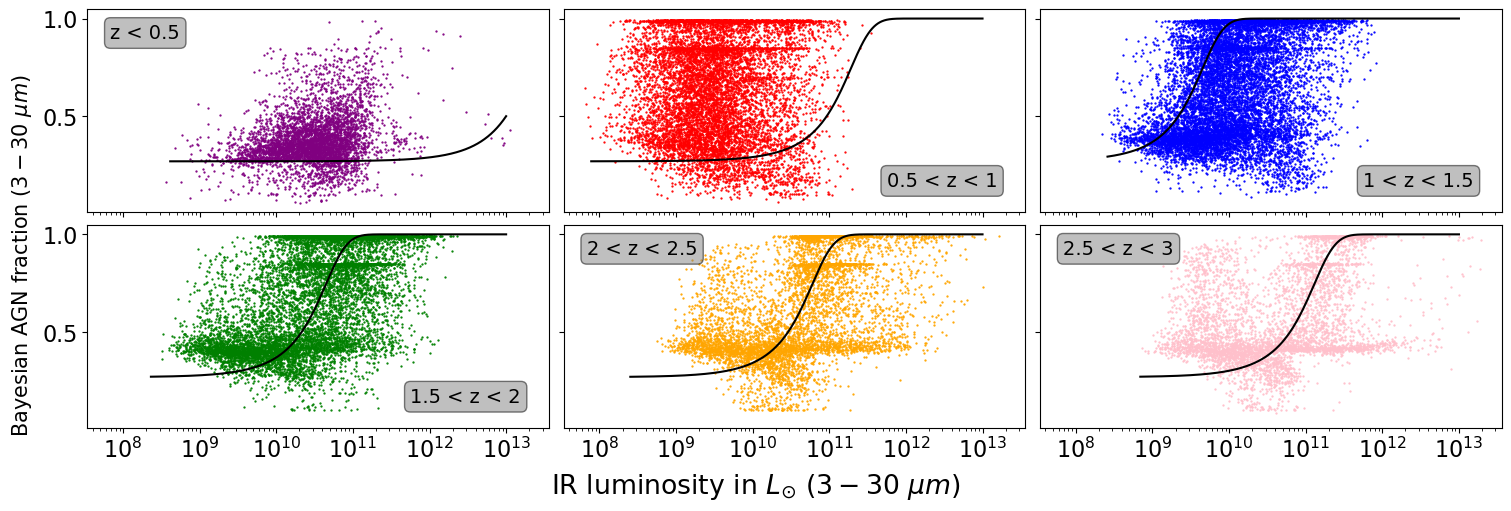

In [12]:
fig, ((ax1,ax2,ax3),(ax4,ax5,ax6)) = plt.subplots(2, 3, figsize=(15,5), sharex=True, sharey=True, layout='constrained')

ax1.scatter(z_05F["IRLum_tot"]/L_sol, 
             z_05F["fAGN_IR"],  
             color="purple",
             s=0.4,
             label="Scatter of IR lum vs fAGN with z < 0.5")

ax2.scatter(z_10F["IRLum_tot"]/L_sol, 
             z_10F["fAGN_IR"],   
             color="red",
             s=0.4,
             label="Scatter of IR lum vs fAGN with 0.5 < z < 1")

ax3.scatter(z_15F["IRLum_tot"]/L_sol, 
             z_15F["fAGN_IR"],  
             color="blue",
             s=0.4,
             label="Scatter of IR lum vs fAGN with 1 < z < 1.5")

ax4.scatter(z_20F["IRLum_tot"]/L_sol, 
             z_20F["fAGN_IR"],  
             color="green",
             s=0.4,
             label="Scatter of IR lum vs fAGN with 1.5 < z < 2")

ax5.scatter(z_25F["IRLum_tot"]/L_sol, 
             z_25F["fAGN_IR"],  
             color="orange",
             s=0.4,
             label="Scatter of IR lum vs fAGN with 2 < z < 2.5")

ax6.scatter(z_30F["IRLum_tot"]/L_sol, 
             z_30F["fAGN_IR"],  
             color="pink",
             s=0.4,
             label="Scatter of IR lum vs fAGN with 2.5 < z")

#Fitting the relation

popt05, pcov05 = curve_fit(new, z_05F["IRLum_tot"]/L_sol, z_05F["fAGN_IR"], sigma=z_05F["fAGN_err"], bounds=((10**9),(10**13)))
popt10, pcov10 = curve_fit(new, z_10F["IRLum_tot"]/L_sol, z_10F["fAGN_IR"], sigma=z_10F["fAGN_err"], bounds=((10**9),(10**13)))
popt15, pcov15 = curve_fit(new, z_15F["IRLum_tot"]/L_sol, z_15F["fAGN_IR"], sigma=z_15F["fAGN_err"], bounds=((10**8),(10**13)))
popt20, pcov20 = curve_fit(new, z_20F["IRLum_tot"]/L_sol, z_20F["fAGN_IR"], sigma=z_20F["fAGN_err"], bounds=((10**9),(10**13)))
popt25, pcov25 = curve_fit(new, z_25F["IRLum_tot"]/L_sol, z_25F["fAGN_IR"], sigma=z_25F["fAGN_err"], bounds=((10**9),(10**13)))
popt30, pcov30 = curve_fit(new, z_30F["IRLum_tot"]/L_sol, z_30F["fAGN_IR"], sigma=z_30F["fAGN_err"], bounds=((10**9),(10**13)))

#Creating logspace for relation points

LIR05 = np.logspace(np.log10(min(z_05SK["IRLum_tot"]/L_sol)),13,1000)
LIR10 = np.logspace(np.log10(min(z_10SK["IRLum_tot"]/L_sol)),13,1000)
LIR15 = np.logspace(np.log10(min(z_15SK["IRLum_tot"]/L_sol)),13,1000)
LIR20 = np.logspace(np.log10(min(z_20SK["IRLum_tot"]/L_sol)),13,1000)
LIR25 = np.logspace(np.log10(min(z_25SK["IRLum_tot"]/L_sol)),13,1000)
LIR30 = np.logspace(np.log10(min(z_30SK["IRLum_tot"]/L_sol)),13,1000)

#plotting the relation line

ax1.plot(LIR05, new(LIR05, *popt05), c="black", label = "Fitted line through the datapoints")
ax2.plot(LIR10, new(LIR10, *popt10), c="black", label = "Fitted line through the datapoints")
ax3.plot(LIR15, new(LIR15, *popt15), c="black", label = "Fitted line through the datapoints")
ax4.plot(LIR20, new(LIR20, *popt20), c="black", label = "Fitted line through the datapoints")
ax5.plot(LIR25, new(LIR25, *popt25), c="black", label = "Fitted line through the datapoints")
ax6.plot(LIR30, new(LIR30, *popt30), c="black", label = "Fitted line through the datapoints")

#setting the axes to logscale

ax1.set_xscale("log")
ax2.set_xscale("log")
ax3.set_xscale("log")
ax4.set_xscale("log")
ax5.set_xscale("log")
ax6.set_xscale("log")

#Creates box with text in the preferred subplot

props = dict(boxstyle='round', facecolor='grey', alpha=0.5)

ax1.text(0.05, 0.93, 'z < 0.5', transform=ax1.transAxes, fontsize=14,
            verticalalignment='top', bbox=props)

ax2.text(0.70, 0.20, '0.5 < z < 1', transform=ax2.transAxes, fontsize=14,
            verticalalignment='top', bbox=props)

ax3.text(0.70, 0.20, '1 < z < 1.5', transform=ax3.transAxes, fontsize=14,
            verticalalignment='top', bbox=props)

ax4.text(0.70, 0.20, '1.5 < z < 2', transform=ax4.transAxes, fontsize=14,
            verticalalignment='top', bbox=props)

ax5.text(0.05, 0.93, '2 < z < 2.5', transform=ax5.transAxes, fontsize=14,
            verticalalignment='top', bbox=props)

ax6.text(0.05, 0.93, '2.5 < z < 3', transform=ax6.transAxes, fontsize=14,
            verticalalignment='top', bbox=props)

# fig.suptitle("Fritz model plots (3-30 $\mu m$)")
fig.supxlabel('IR luminosity in $L_{\odot}$ ($3-30\ \mu m$)')
fig.supylabel('Bayesian AGN fraction ($3-30\ \mu m$)', fontsize=15)

plt.show()

# SKIRTOR vs. Fritz Contour plots

In [ ]:
# Help from ChatGPT to figure out how to use gaussian_kde and https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.gaussian_kde.html

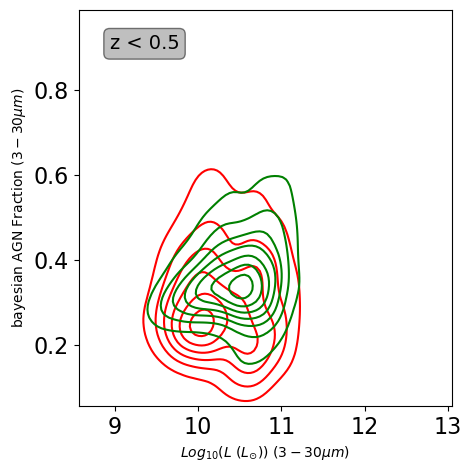

In [21]:
# Retrieve the data from bins

IRLum_SK = z_05SK["IRLum_tot"] / L_sol
fAGN_SK = z_05SK["fAGN_IR"]

IRLum_F = z_05F["IRLum_tot"] / L_sol
fAGN_F = z_05F["fAGN_IR"]

# Use KDE to create 3 arrays, X being the IR luminosities, Y being the AGN fractions and Z being the created depth of the contours

## SKIRTOR
xmin_SK, xmax_SK = np.log10(IRLum_SK.min()), np.log10(IRLum_SK.max())
ymin_SK, ymax_SK = fAGN_SK.min(), fAGN_SK.max()

xy_SK = np.vstack([np.log10(IRLum_SK), fAGN_SK])
kde_SK = gaussian_kde(xy_SK)

X05_SK, Y05_SK = np.mgrid[xmin_SK:xmax_SK:100j, ymin_SK:ymax_SK:100j]
positions_SK = np.vstack([X05_SK.ravel(), Y05_SK.ravel()])
Z05_SK = np.reshape(kde_SK(positions_SK).T, X05_SK.shape)

## Fritz
xmin_F, xmax_F = np.log10(IRLum_F.min()), np.log10(IRLum_F.max())
ymin_F, ymax_F = fAGN_F.min(), fAGN_F.max()

xy_F = np.vstack([np.log10(IRLum_F), fAGN_F])
kde_F = gaussian_kde(xy_F)

X05_F, Y05_F = np.mgrid[xmin_F:xmax_F:100j, ymin_F:ymax_F:100j]
positions_F = np.vstack([X05_F.ravel(), Y05_F.ravel()])
Z05_F = np.reshape(kde_F(positions_F).T, X05_F.shape)

# plotting

fig, ax = plt.subplots(figsize=(5, 5))

SK05 = ax.contour(X05_SK, Y05_SK, Z05_SK, colors='red')

F05 = ax.contour(X05_F, Y05_F, Z05_F, colors='green')

SK,_ = SK05.legend_elements()
F,_ = F05.legend_elements()

ax.get_xaxis().set_major_formatter(plt.ScalarFormatter())

ax.set_xlabel(r"$Log_{10}(L\ (L_{\odot}))$ ($3-30 \mu m$)", fontsize=10)
ax.set_ylabel(r"bayesian AGN Fraction ($3-30 \mu m$)", fontsize=10)
# ax.set_title("Density Contour Plot for z < 0.5")

props = dict(boxstyle='round', facecolor='grey', alpha=0.5)

ax.text(-0.05, 0.93, 'z < 0.5', transform=ax1.transAxes, fontsize=14,
            verticalalignment='top', bbox=props)

plt.tight_layout()
# plt.legend([SK[0], F[0]], ['SKIRTOR contour', 'Fritz contour'])
plt.show()

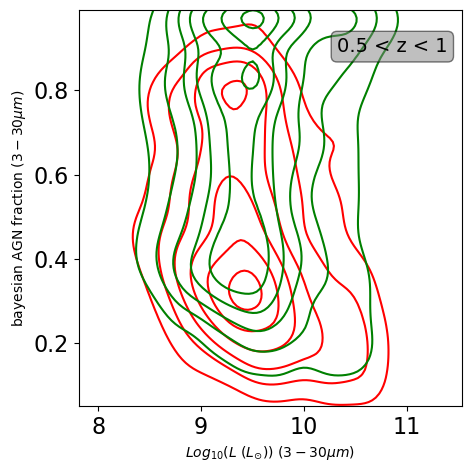

In [33]:
# Retrieve the data from bins

IRLum_SK = z_10SK["IRLum_tot"] / L_sol
fAGN_SK = z_10SK["fAGN_IR"]

IRLum_F = z_10F["IRLum_tot"] / L_sol
fAGN_F = z_10F["fAGN_IR"]

# Use KDE to create 3 arrays, X being the IR luminosities, Y being the AGN fractions and Z being the created depth of the contours

## SKIRTOR
xmin_SK, xmax_SK = np.log10(IRLum_SK.min()), np.log10(IRLum_SK.max())
ymin_SK, ymax_SK = fAGN_SK.min(), fAGN_SK.max()

xy_SK = np.vstack([np.log10(IRLum_SK), fAGN_SK])
kde_SK = gaussian_kde(xy_SK)

X10_SK, Y10_SK = np.mgrid[xmin_SK:xmax_SK:100j, ymin_SK:ymax_SK:100j]
positions_SK = np.vstack([X10_SK.ravel(), Y10_SK.ravel()])
Z10_SK = np.reshape(kde_SK(positions_SK).T, X10_SK.shape)

## Fritz
xmin_F, xmax_F = np.log10(IRLum_F.min()), np.log10(IRLum_F.max())
ymin_F, ymax_F = fAGN_F.min(), fAGN_F.max()

xy_F = np.vstack([np.log10(IRLum_F), fAGN_F])
kde_F = gaussian_kde(xy_F)

X10_F, Y10_F = np.mgrid[xmin_F:xmax_F:100j, ymin_F:ymax_F:100j]
positions_F = np.vstack([X10_F.ravel(), Y10_F.ravel()])
Z10_F = np.reshape(kde_F(positions_F).T, X10_F.shape)

# plotting

fig, ax = plt.subplots(figsize=(5, 5))

SK10 = ax.contour(X10_SK, Y10_SK, Z10_SK, colors='red')

F10 = ax.contour(X10_F, Y10_F, Z10_F, colors='green')

SK,_ = SK10.legend_elements()
F,_ = F10.legend_elements()

ax.get_xaxis().set_major_formatter(plt.ScalarFormatter())

ax.set_xlabel(r"$Log_{10}(L\ (L_{\odot}))$ ($3-30 \mu m$)", fontsize=10)
ax.set_ylabel(r"bayesian AGN fraction ($3-30 \mu m$)", fontsize=10)
# ax.set_title("Density Contour Plot for 0.5 < z < 1")

props = dict(boxstyle='round', facecolor='grey', alpha=0.5)

ax.text(0.48, 0.91, '0.5 < z < 1', transform=ax1.transAxes, fontsize=14,
            verticalalignment='top', bbox=props)

plt.tight_layout()
# plt.legend([SK[0], F[0]], ['SKIRTOR contour', 'Fritz contour'])
plt.show()

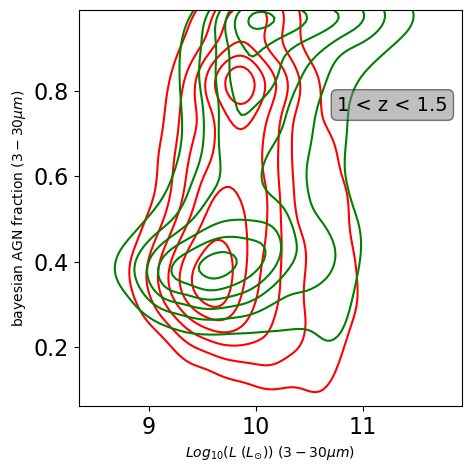

In [32]:
# Retrieve the data from bins

IRLum_SK = z_15SK["IRLum_tot"] / L_sol
fAGN_SK = z_15SK["fAGN_IR"]

IRLum_F = z_15F["IRLum_tot"] / L_sol
fAGN_F = z_15F["fAGN_IR"]

# Use KDE to create 3 arrays, X being the IR luminosities, Y being the AGN fractions and Z being the created depth of the contours

## SKIRTOR
xmin_SK, xmax_SK = np.log10(IRLum_SK.min()), np.log10(IRLum_SK.max())
ymin_SK, ymax_SK = fAGN_SK.min(), fAGN_SK.max()

xy_SK = np.vstack([np.log10(IRLum_SK), fAGN_SK])
kde_SK = gaussian_kde(xy_SK)

X15_SK, Y15_SK = np.mgrid[xmin_SK:xmax_SK:100j, ymin_SK:ymax_SK:100j]
positions_SK = np.vstack([X15_SK.ravel(), Y15_SK.ravel()])
Z15_SK = np.reshape(kde_SK(positions_SK).T, X15_SK.shape)

## Fritz
xmin_F, xmax_F = np.log10(IRLum_F.min()), np.log10(IRLum_F.max())
ymin_F, ymax_F = fAGN_F.min(), fAGN_F.max()

xy_F = np.vstack([np.log10(IRLum_F), fAGN_F])
kde_F = gaussian_kde(xy_F)

X15_F, Y15_F = np.mgrid[xmin_F:xmax_F:100j, ymin_F:ymax_F:100j]
positions_F = np.vstack([X15_F.ravel(), Y15_F.ravel()])
Z15_F = np.reshape(kde_F(positions_F).T, X15_F.shape)

# plotting

fig, ax = plt.subplots(figsize=(5, 5))

SK15 = ax.contour(X15_SK, Y15_SK, Z15_SK, colors='red')

F15 = ax.contour(X15_F, Y15_F, Z15_F, colors='green')

SK,_ = SK15.legend_elements()
F,_ = F15.legend_elements()

ax.get_xaxis().set_major_formatter(plt.ScalarFormatter())

ax.set_xlabel(r"$Log_{10}(L\ (L_{\odot}))$ ($3-30 \mu m$)", fontsize=10)
ax.set_ylabel(r"bayesian AGN fraction ($3-30 \mu m$)", fontsize=10)
# ax.set_title("Density Contour Plot for 1 < z < 1.5")

props = dict(boxstyle='round', facecolor='grey', alpha=0.5)

ax.text(0.48, 0.50, '1 < z < 1.5', transform=ax1.transAxes, fontsize=14,
            verticalalignment='top', bbox=props)

plt.tight_layout()
# plt.legend([SK[0], F[0]], ['SKIRTOR contour', 'Fritz contour'])
plt.show()

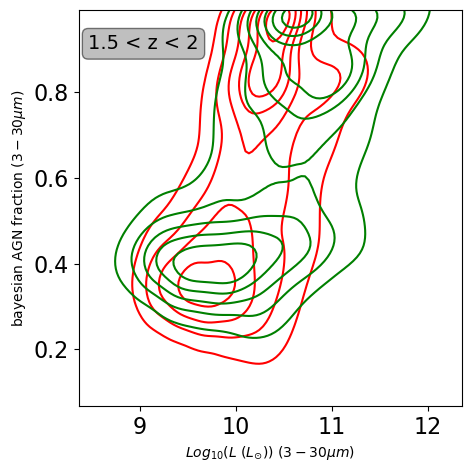

In [37]:
# Retrieve the data from bins

IRLum_SK = z_20SK["IRLum_tot"] / L_sol
fAGN_SK = z_20SK["fAGN_IR"]

IRLum_F = z_20F["IRLum_tot"] / L_sol
fAGN_F = z_20F["fAGN_IR"]

# Use KDE to create 3 arrays, X being the IR luminosities, Y being the AGN fractions and Z being the created depth of the contours

## SKIRTOR
xmin_SK, xmax_SK = np.log10(IRLum_SK.min()), np.log10(IRLum_SK.max())
ymin_SK, ymax_SK = fAGN_SK.min(), fAGN_SK.max()

xy_SK = np.vstack([np.log10(IRLum_SK), fAGN_SK])
kde_SK = gaussian_kde(xy_SK)

X20_SK, Y20_SK = np.mgrid[xmin_SK:xmax_SK:100j, ymin_SK:ymax_SK:100j]
positions_SK = np.vstack([X20_SK.ravel(), Y20_SK.ravel()])
Z20_SK = np.reshape(kde_SK(positions_SK).T, X20_SK.shape)

##Fritz
xmin_F, xmax_F = np.log10(IRLum_F.min()), np.log10(IRLum_F.max())
ymin_F, ymax_F = fAGN_F.min(), fAGN_F.max()

xy_F = np.vstack([np.log10(IRLum_F), fAGN_F])
kde_F = gaussian_kde(xy_F)

X20_F, Y20_F = np.mgrid[xmin_F:xmax_F:100j, ymin_F:ymax_F:100j]
positions_F = np.vstack([X20_F.ravel(), Y20_F.ravel()])
Z20_F = np.reshape(kde_F(positions_F).T, X20_F.shape)

# plotting

fig, ax = plt.subplots(figsize=(5, 5))

SK20 = ax.contour(X20_SK, Y20_SK, Z20_SK, colors='red')

F20 = ax.contour(X20_F, Y20_F, Z20_F, colors='green')

SK,_ = SK20.legend_elements()
F,_ = F20.legend_elements()

ax.get_xaxis().set_major_formatter(plt.ScalarFormatter())

ax.set_xlabel(r"$Log_{10}(L\ (L_{\odot}))$ ($3-30 \mu m$)", fontsize=10)
ax.set_ylabel(r"bayesian AGN fraction ($3-30 \mu m$)", fontsize=10)
# ax.set_title("Density Contour Plot for 1.5 < z < 2")

props = dict(boxstyle='round', facecolor='grey', alpha=0.5)

ax.text(-0.10, 0.93, '1.5 < z < 2', transform=ax1.transAxes, fontsize=14,
            verticalalignment='top', bbox=props)

plt.tight_layout()
# plt.legend([SK[0], F[0]], ['SKIRTOR contour', 'Fritz contour'])
plt.show()

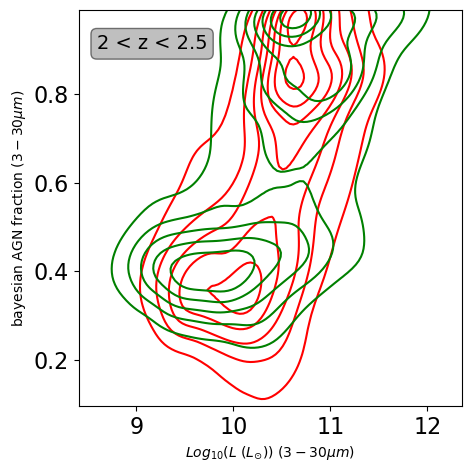

In [41]:
# Retrieve the data from bins

IRLum_SK = z_25SK["IRLum_tot"] / L_sol
fAGN_SK = z_25SK["fAGN_IR"]

IRLum_F = z_20F["IRLum_tot"] / L_sol
fAGN_F = z_20F["fAGN_IR"]

# Use KDE to create 3 arrays, X being the IR luminosities, Y being the AGN fractions and Z being the created depth of the contours

## SKIRTOR
xmin_SK, xmax_SK = np.log10(IRLum_SK.min()), np.log10(IRLum_SK.max())
ymin_SK, ymax_SK = fAGN_SK.min(), fAGN_SK.max()

xy_SK = np.vstack([np.log10(IRLum_SK), fAGN_SK])
kde_SK = gaussian_kde(xy_SK)

X25_SK, Y25_SK = np.mgrid[xmin_SK:xmax_SK:100j, ymin_SK:ymax_SK:100j]
positions_SK = np.vstack([X25_SK.ravel(), Y25_SK.ravel()])
Z25_SK = np.reshape(kde_SK(positions_SK).T, X25_SK.shape)

## Fritz
xmin_F, xmax_F = np.log10(IRLum_F.min()), np.log10(IRLum_F.max())
ymin_F, ymax_F = fAGN_F.min(), fAGN_F.max()

xy_F = np.vstack([np.log10(IRLum_F), fAGN_F])
kde_F = gaussian_kde(xy_F)

X25_F, Y25_F = np.mgrid[xmin_F:xmax_F:100j, ymin_F:ymax_F:100j]
positions_F = np.vstack([X25_F.ravel(), Y25_F.ravel()])
Z25_F = np.reshape(kde_F(positions_F).T, X25_F.shape)

# plotting
fig, ax = plt.subplots(figsize=(5, 5))

SK25 = ax.contour(X25_SK, Y25_SK, Z25_SK, colors='red')

F25 = ax.contour(X25_F, Y25_F, Z25_F, colors='green')

SK,_ = SK25.legend_elements()
F,_ = F25.legend_elements()

ax.get_xaxis().set_major_formatter(plt.ScalarFormatter())

ax.set_xlabel(r"$Log_{10}(L\ (L_{\odot}))$ ($3-30 \mu m$)", fontsize=10)
ax.set_ylabel(r"bayesian AGN fraction ($3-30 \mu m$)", fontsize=10)
# ax.set_title("Density Contour Plot for 2 < z < 2.5")

props = dict(boxstyle='round', facecolor='grey', alpha=0.5)

ax.text(-0.08, 0.93, '2 < z < 2.5', transform=ax1.transAxes, fontsize=14,
            verticalalignment='top', bbox=props)

plt.tight_layout()
# plt.legend([SK[0], F[0]], ['SKIRTOR contour', 'Fritz contour'])
plt.show()

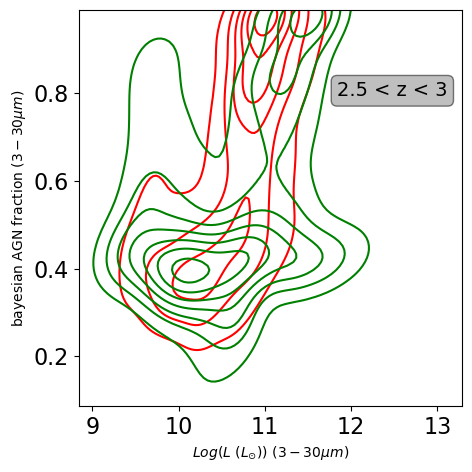

In [42]:
# Retrieve the data from bins

IRLum_SK = z_30SK["IRLum_tot"] / L_sol
fAGN_SK = z_30SK["fAGN_IR"]

IRLum_F = z_30F["IRLum_tot"] / L_sol
fAGN_F = z_30F["fAGN_IR"]

# Use KDE to create 3 arrays, X being the IR luminosities, Y being the AGN fractions and Z being the created depth of the contours

## SKIRTOR
xmin_SK, xmax_SK = np.log10(IRLum_SK.min()), np.log10(IRLum_SK.max())
ymin_SK, ymax_SK = fAGN_SK.min(), fAGN_SK.max()

xy_SK = np.vstack([np.log10(IRLum_SK), fAGN_SK])
kde_SK = gaussian_kde(xy_SK)

X30_SK, Y30_SK = np.mgrid[xmin_SK:xmax_SK:100j, ymin_SK:ymax_SK:100j]
positions_SK = np.vstack([X30_SK.ravel(), Y30_SK.ravel()])
Z30_SK = np.reshape(kde_SK(positions_SK).T, X30_SK.shape)

## Fritz
xmin_F, xmax_F = np.log10(IRLum_F.min()), np.log10(IRLum_F.max())
ymin_F, ymax_F = fAGN_F.min(), fAGN_F.max()

xy_F = np.vstack([np.log10(IRLum_F), fAGN_F])
kde_F = gaussian_kde(xy_F)

X30_F, Y30_F = np.mgrid[xmin_F:xmax_F:100j, ymin_F:ymax_F:100j]
positions_F = np.vstack([X30_F.ravel(), Y30_F.ravel()])
Z30_F = np.reshape(kde_F(positions_F).T, X30_F.shape)

# plotting

fig, ax = plt.subplots(figsize=(5, 5))

SK30 = ax.contour(X30_SK, Y30_SK, Z30_SK, colors='red')

F30 = ax.contour(X30_F, Y30_F, Z30_F, colors='green')

SK,_ = SK30.legend_elements()
F,_ = F30.legend_elements()

ax.get_xaxis().set_major_formatter(plt.ScalarFormatter())

ax.set_xlabel(r"$Log(L\ (L_{\odot}))$ ($3-30 \mu m$)", fontsize=10)
ax.set_ylabel(r"bayesian AGN fraction ($3-30 \mu m$)", fontsize=10)
# ax.set_title("Density Contour Plot for 2.5 < z < 3")

props = dict(boxstyle='round', facecolor='grey', alpha=0.5)

ax.text(0.48, 0.60, '2.5 < z < 3', transform=ax1.transAxes, fontsize=14,
            verticalalignment='top', bbox=props)

plt.tight_layout()
# plt.legend([SK[0], F[0]], ['SKIRTOR contour', 'Fritz contour'])
plt.show()

/var/lib/condor/execute/dir_330080/ipykernel_330467/2357391150.py:45: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


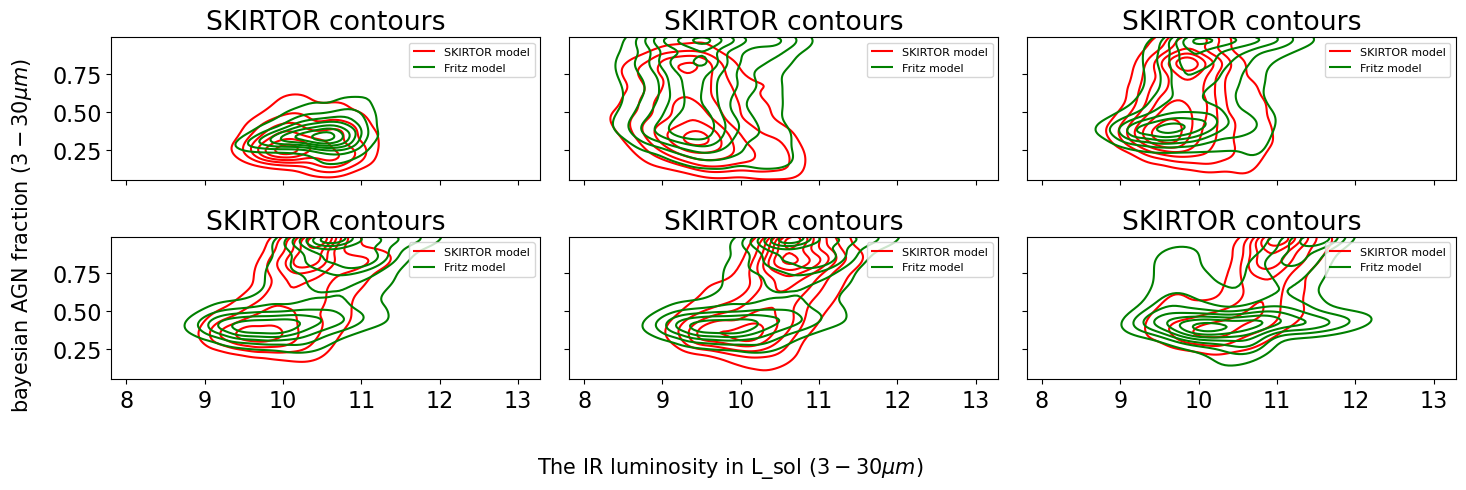

In [15]:
fig, ((ax1,ax2,ax3),(ax4,ax5,ax6)) = plt.subplots(2, 3, figsize=(15,5), sharex=True, sharey=True, layout='constrained')

z05_SK = ax1.contour(X05_SK, Y05_SK, Z05_SK, colors='red')
z05_F = ax1.contour(X05_F, Y05_F, Z05_F, colors='green')

ax2.contour(X10_SK, Y10_SK, Z10_SK, colors='red')
ax2.contour(X10_F, Y10_F, Z10_F, colors='green')

ax3.contour(X15_SK, Y15_SK, Z15_SK, colors='red')
ax3.contour(X15_F, Y15_F, Z15_F, colors='green')

ax4.contour(X20_SK, Y20_SK, Z20_SK, colors='red')
ax4.contour(X20_F, Y20_F, Z20_F, colors='green')

ax5.contour(X25_SK, Y25_SK, Z25_SK, colors='red')
ax5.contour(X25_F, Y25_F, Z25_F, colors='green')

ax6.contour(X30_SK, Y30_SK, Z30_SK, colors='red')
ax6.contour(X30_F, Y30_F, Z30_F, colors='green')

hSK,_ = z05_SK.legend_elements()
hF,_ = z05_F.legend_elements()

ax1.legend([hSK[0], hF[0]], ['SKIRTOR model', 'Fritz model'], fontsize=8)
ax1.set_title("SKIRTOR contours")

ax2.legend([hSK[0], hF[0]], ['SKIRTOR model', 'Fritz model'], fontsize=8)
ax2.set_title("SKIRTOR contours")

ax3.legend([hSK[0], hF[0]], ['SKIRTOR model', 'Fritz model'], fontsize=8)
ax3.set_title("SKIRTOR contours")

ax4.legend([hSK[0], hF[0]], ['SKIRTOR model', 'Fritz model'], fontsize=8)
ax4.set_title("SKIRTOR contours")

ax5.legend([hSK[0], hF[0]], ['SKIRTOR model', 'Fritz model'], fontsize=8)
ax5.set_title("SKIRTOR contours")

ax6.legend([hSK[0], hF[0]], ['SKIRTOR model', 'Fritz model'], fontsize=8)
ax6.set_title("SKIRTOR contours")

fig.supxlabel("The IR luminosity in L_sol ($3-30 \mu m$)", fontsize=15)
fig.supylabel(r"bayesian AGN fraction ($3-30 \mu m$)", fontsize=15)

plt.tight_layout()
plt.show()